<img src="images/GEMS Informatics Learning.png" width=500 alt="GEMS Logo" title="GEMS" />

# **Basic geocomputation with raster data in R**

**Instructors:**  
Yuan Chai (chaix026@umn.edu)  
Ali Joglekar (joglekar@umn.edu)  

---

## Method of Delivery
- Workshop text, images and R code are all contained within a Jupyter Notebook hosted on the GEMS Informatics Platform. You do not need to have R or RStudio installed on your machine to participate
- A recording of the workshop will be posted on Canvas
- Please download any desired materials, as we cannot guarantee access to the Canvas course beyond 3 months.  

---  

## Module Outline: 
- [Raster data in R](#Raster)  
  - [Exercise 1](#Ex1)
- [Raster manipulation](#Manipulation) 
- [Spatial operations](#SpOp)
  - [Exercise 2](#Ex2)
- [Geometry operations](#GeomOp)  
  - [Exercise 3](#Ex3)
- [Raster-Vector interactions](#RasVec)
  - [Exercise 4](#Ex4)

---  


### **Load R Libraries**

In [6]:
# Install and load packages needed for this workshop

packages_to_load <- c("raster", "terra", "sf", "tmap", "data.table")

for ( package in packages_to_load ) {
    # Check if package is already installed, if not, install and load the package
    if (!require(package, character.only=T, quietly=T, warn.conflicts=F)) {
        install.packages(package)
        suppressPackageStartupMessages(library(package, character.only=T, quietly=T, warn.conflicts=F))
    }
}

# Set plot options
options(repr.plot.width = 8, repr.plot.height = 4)


<details>
    
<summary><span style='color:Green'> Note: For your own work, once packages are installed, it is recommended to just use library() to load your packages  </span></summary>


```
# Spatial data libraries
library(raster)
library(sf)

# Plotting libraries
library(tmap)

# General data analysis libraries
library(data.table)
```
----
          
</details>


### Data

Your expercises will draw on datasets from the Spatial Production Allocation Model (SPAM) and Minnesota Geospatial Commons, which have been downloaded, cleaned, transformed and saved in the directory `./data/MN` for this workshop.

1. \[RASTERS\] Crop production at 10x10km grid-cell resolution from MAPSPAM (Spatial Production Allocation Model) data center  https://www.mapspam.info/data/
2. \[POLYGONS\] Groundwater Provinces of Minnesota 2021: https://gisdata.mn.gov/dataset/geos-groundwater-provinces-mn


### Attribution

The following material draws heavily from Robin Lovelace's [Geocomputation with R](https://geocompr.robinlovelace.net/index.html) textbook.

<a id="Raster"></a>
## **What is raster data?**

In its simplest form, a raster consists of a matrix of cells (or pixels) organized into rows and columns (or a grid) where each cell contains a value representing information, such as temperature.  
Rasters can be digital aerial photographs, imagery from satellites, digital pictures, or even scanned maps.

<img src="https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/GUID-6754AF39-CDE9-4F9D-8C3A-D59D93059BDD-web.png" />


### **Creating `Raster*` objects in R**

In this workshop, we will focus on using the `terra` package for raster data analysis in R
R package `terra` is designed to replace the old favourite `raster`. It is made by a similar team. The `terra` documentation states that `terra` “can do more, is simpler to use, and it is faster.” 

Raster data structure in R:  
- Number of rows
- Number of columns
- Bounding box (extent)
- Resolution
- Coordinate reference system (projection)  

Create an empty `SpatRaster` object with 6 rows and 6 columns within bounding box (-1.5, 1.5, -1.5, 1.5)

In [3]:
ras <- rast(nrow = 6, ncol = 6, xmin = -1.5, xmax = 1.5, ymin = -1.5, ymax = 1.5)
ras

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 


The objects `ras` created in the example above only consist of the raster ‘geometry’, that is, we have defined the number of rows and columns, and where the raster is located in geographic space, but there are no cell-values associated with it. 

Setting and accessing values using the `values()` function


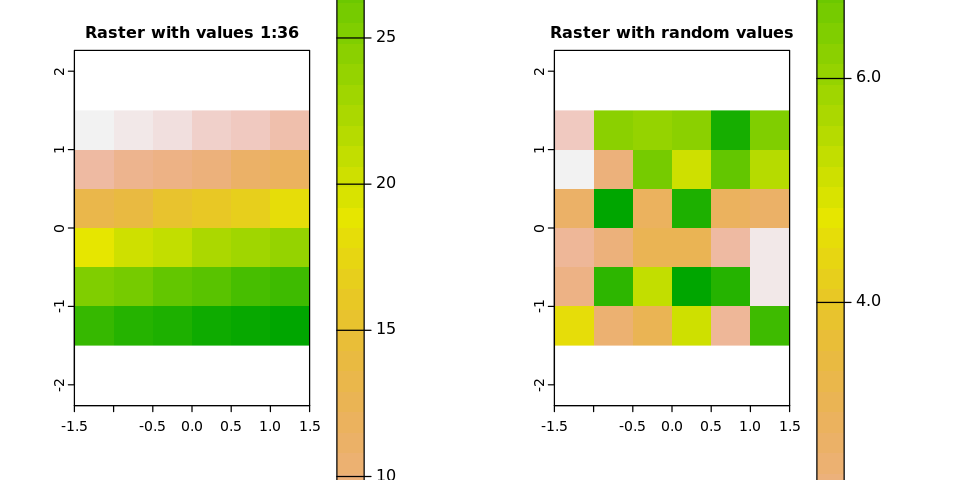

In [4]:
# Assign known values to raster cells
ras_a <- ras
values(ras_a) <- 1:ncell(ras_a)

# Assign random values to raster cells
ras_b <- ras
set.seed(1234)
values(ras_b) <- runif(ncell(ras_b))*10

# plot two rasters
par(mfrow=c(1,2))
plot(ras_a, main="Raster with values 1:36")
plot(ras_b, main="Raster with random values")

### Attributes
Raster cells can only possess one value which can be linked to other attributes via attribute table stored in `attributes` slot

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
source      : memory 
name        : lyr.1 
min value   :  clay 
max value   :  silt 

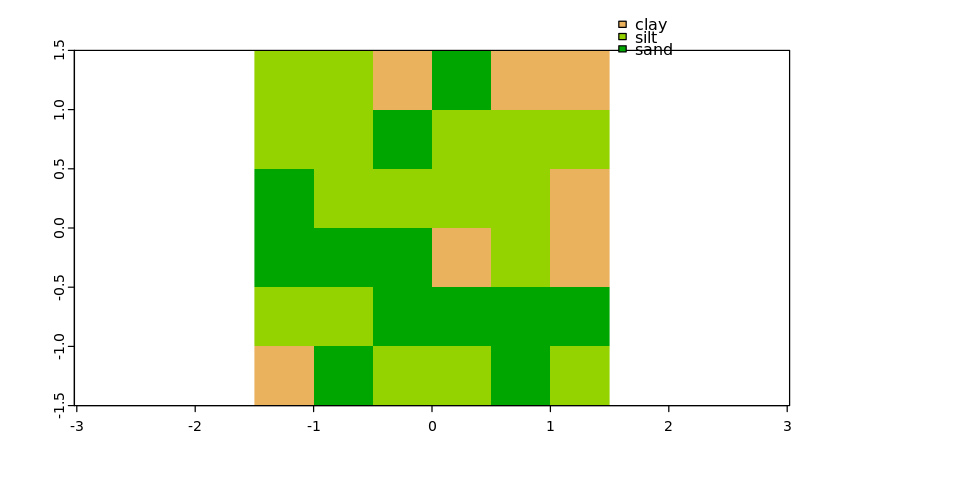

In [5]:
soil_order = c("clay", "silt", "sand")
set.seed(1234)
soil_char = sample(soil_order, 36, replace = TRUE)
soil_fact = factor(soil_char, levels = soil_order)
soil = rast(nrow = 6, ncol = 6, res = 0.5, 
               xmin = -1.5, xmax = 1.5, ymin = -1.5, ymax = 1.5,
               vals = soil_fact)
soil
plot(soil)

### Summarizing raster layer

In [7]:
nrow(ras_a) # number of rows

[1] 6

In [8]:
ncol(ras_a) # number of columns

[1] 6

In [9]:
ncell(ras_a) # number of cells

[1] 36

In [11]:
ext(ras_a) # raster extent

SpatExtent : -1.5, 1.5, -1.5, 1.5 (xmin, xmax, ymin, ymax)

In [12]:
res(ras_a) # resolution

[1] 0.5 0.5

In [13]:
crs(ras_a) # coordiante reference system

[1] "GEOGCRS[\"WGS 84\",\n    DATUM[\"World Geodetic System 1984\",\n        ELLIPSOID[\"WGS 84\",6378137,298.257223563,\n            LENGTHUNIT[\"metre\",1]],\n        ID[\"EPSG\",6326]],\n    PRIMEM[\"Greenwich\",0,\n        ANGLEUNIT[\"degree\",0.0174532925199433],\n        ID[\"EPSG\",8901]],\n    CS[ellipsoidal,2],\n        AXIS[\"longitude\",east,\n            ORDER[1],\n            ANGLEUNIT[\"degree\",0.0174532925199433,\n                ID[\"EPSG\",9122]]],\n        AXIS[\"latitude\",north,\n            ORDER[2],\n            ANGLEUNIT[\"degree\",0.0174532925199433,\n                ID[\"EPSG\",9122]]]]"

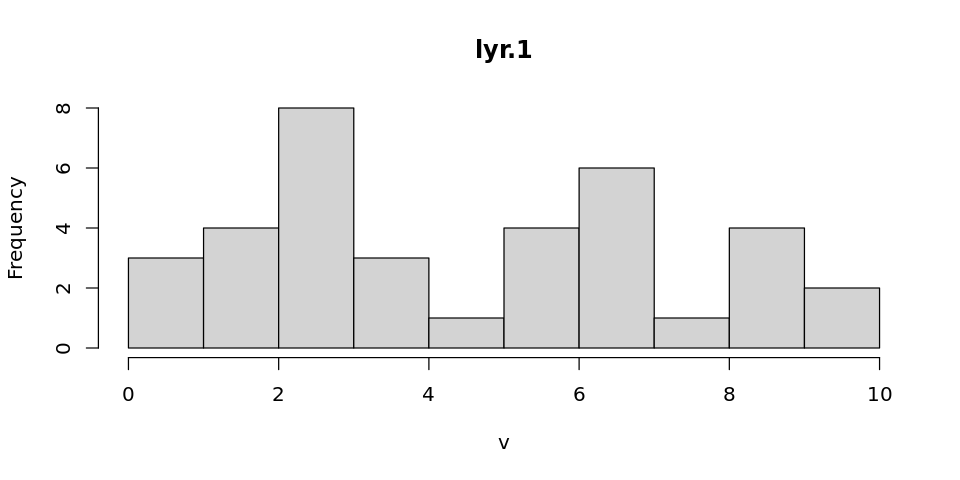

In [14]:
hist(ras_b)  # histogram of raster cell values

### Multi-layer raster 

You can create a multi-layer `SpatRaster` object **with the same spatial extent and resolution** using the `c` method.  

In [15]:
r_stack = c(ras_a, ras_b, soil)
names(r_stack) = c("area", "prod" , "soil")
r_stack

class       : SpatRaster 
dimensions  : 6, 6, 3  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
sources     : memory  
              memory  
              memory  
names       :       area,       prod, soil 
min values  : 1.00000000, 0.09495756, clay 
max values  :  36.000000,   9.234335, silt 

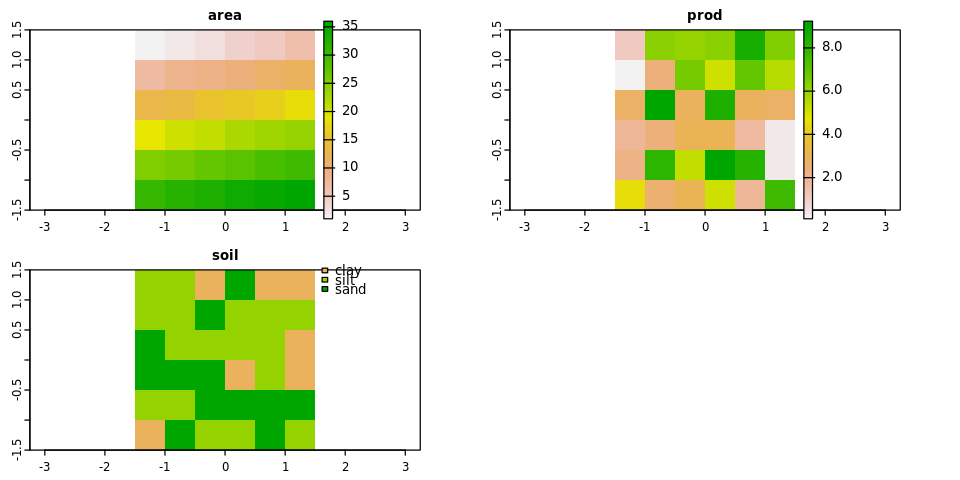

In [16]:
plot(r_stack)

<a id="Ex1"></a>
### **<span style='color:Green'> Exercise 1: Read in raster files and create raster stack </span>**   

In this exercise, we will first read in raster files (in `.tif` format) which contains the maize harvested area and production in Minnesota and then create a raster stack.  


**Step 1:** Use the `rast()` function to read in raster files from the `"./data/MN/spam/"` directory.    

>file `"./data/MN/spam/spam_H_MAIZ_A_mn.tif"` is the Harvested Area (in hecacres) for Maize in Minnesota  
>file `"./data/MN/spam/spam_P_MAIZ_A_mn.tif"` is the Production (in metric tons) for Maize in Minnesota  

Use various summarizing functions (e.g., `ext()`, `res()`, `crs()`) to check the two raster files having the same extent and resolution

In [17]:
# Read in raster files
spam_H_MAIZ_A_mn <- rast("./data/MN/spam/spam_H_MAIZ_A_mn.tif")
spam_P_MAIZ_A_mn <- rast("./data/MN/spam/spam_P_MAIZ_A_mn.tif")

In [19]:
# Check for extent, resolution, and crs


<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Read in raster files
spam_H_MAIZ_A_mn <- rast("./data/MN/spam/spam_H_MAIZ_A_mn.tif")
spam_P_MAIZ_A_mn <- rast("./data/MN/spam/spam_P_MAIZ_A_mn.tif")

# Check for extent, resolution, and crs
ext(spam_H_MAIZ_A_mn)
ext(spam_P_MAIZ_A_mn)

res(spam_H_MAIZ_A_mn)
res(spam_P_MAIZ_A_mn)

crs(spam_H_MAIZ_A_mn)
crs(spam_P_MAIZ_A_mn)
```
----
          
</details>

**Step 2:** Use `c()` function to create a multi-layer raster with both area and production layers and rename the layers to "Area" and "Prod"    

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
spam_MAIZ_A_mn <- c(spam_H_MAIZ_A_mn, spam_P_MAIZ_A_mn)
names(spam_MAIZ_A_mn) <- c("Area", "Prod")
```
----
          
</details>

**Step 3:** Use `plot()` and `hist()` functions to explore your RasterStack    

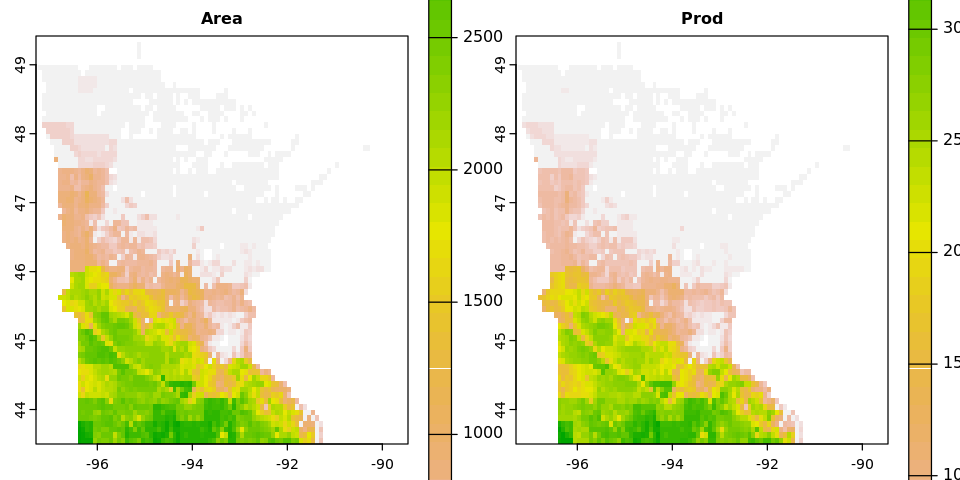

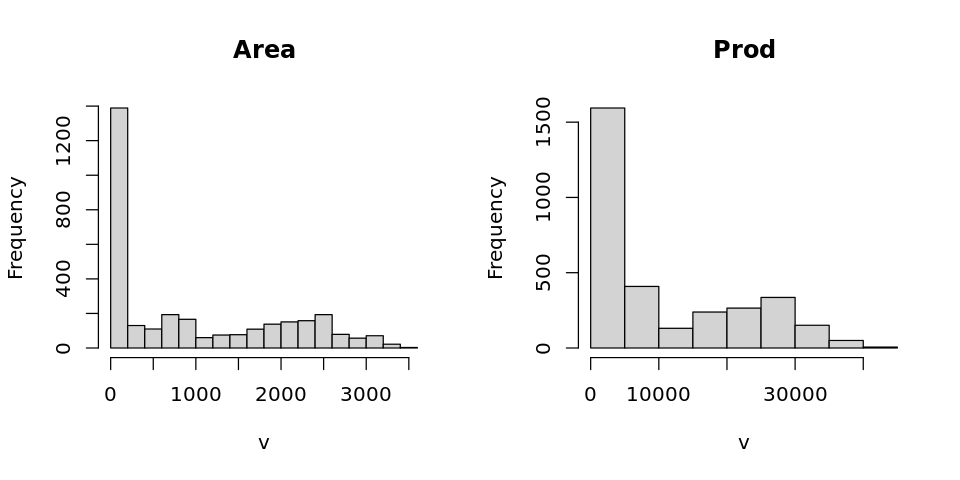

In [21]:
plot(spam_MAIZ_A_mn) 
hist(spam_MAIZ_A_mn)

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
plot(spam_MAIZ_A_mn) 
hist(spam_MAIZ_A_mn)
```
----
          
</details>

<a id="Manipulation"></a>
## **Raster Manipulation**

### Raster Subset
Raster subsetting is done with the base R operator `[  ]`


In [32]:
# row 3, column 3
ras_a[3, 3]
# cell ID 15
ras_a[15]

lyr.1
<int>
15


lyr.1
<int>
15


Extracting all values or complete rows, you can use `values()` and `getValues()`

In [42]:
# all values
values(ras_a, mat=FALSE, dataframe=FALSE)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36

In [44]:
# row 3-4
values(ras_a, mat=FALSE, dataframe=FALSE, row = 3, nrows = 2, col=1, ncols=2)

[1] 13 14 19 20

### Multi-layer Raster Subset  
The `subset`, `[[ ]]` or `$` command extracts layers from a multi-layer raster.

In [45]:
# Method 1
subset(r_stack, "area")

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
source      : memory 
name        : area 
min value   :    1 
max value   :   36 

In [46]:
# Method 2
r_stack[["area"]]

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
source      : memory 
name        : area 
min value   :    1 
max value   :   36 

In [47]:
# Method 3
r_stack$area

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
source      : memory 
name        : area 
min value   :    1 
max value   :   36 

<a id="SpOp"></a>
## **Spatial Operations**
Modifying raster objects based on their location and shape



### Map algebra  
Map algebra makes raster processing really fast.
This is because raster datasets only implicitly store coordinates. 
If two or more raster datasets share the same extent, projection and resolution, one could treat them as matrices for the processing.
This is exactly what map algebra is doing in R.

Map algebra divides raster operations into four subclasses, with each working on one or several grids simultaneously:

1. **Local** or per-cell operations
2. **Focal** or neighborhood operations
3. **Zonal** operations are similar to focal operations, but the surrounding pixel grid on which new values are computed can have irregular sizes and shapes
4. **Global** or per-raster operations

#### **Local operations**
**Local** operations comprise all cell-by-cell operations in one or several layers.

Many generic functions that allow for simple and elegant raster algebra have been implemented for Raster objects, including the normal algebraic operators such as `+`, `-`, `*`, `/`, logical operators such as `>`, `>=`, `<`, `==`, `!` and functions like `abs`, `round`, `ceiling`, `floor`, `trunc`, `sqrt`, `log`, `log10`, `exp`, `cos`, `sin`, `atan`, `tan`, `max`, `min`, `range`, `prod`, `sum`, `any`, `all`. In these functions you can mix raster objects with numbers, as long as the first argument is a raster object.



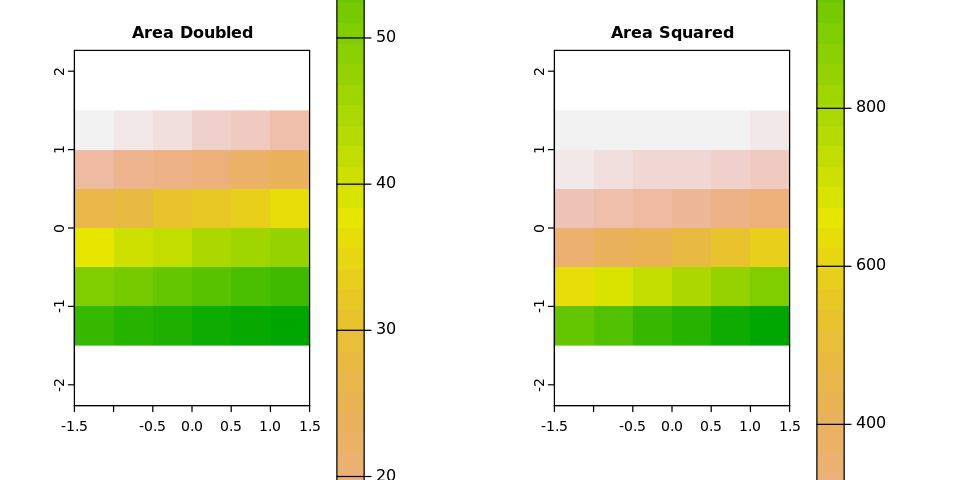

In [48]:
area <- ras_a
areaX2 <- area*2
areaSq <- area^2

# Plot
par(mfrow=c(1,2))
plot(areaX2, main="Area Doubled")
plot(areaSq, main="Area Squared")

Summary functions (`min, max, mean, prod, sum, Median, cv, range, any, all`) always return a RasterLayer object. Perhaps this is not obvious when using functions like `min, sum or mean`.

In [49]:
mean(areaX2, areaSq)

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
source      : memory 
name        : lyr.1 
min value   :   1.5 
max value   :   684 

Raster algebra also allows logical operations such as finding all raster cells that are greater than a specific value.  
You can also use replacement functions to change values based on logical operations.

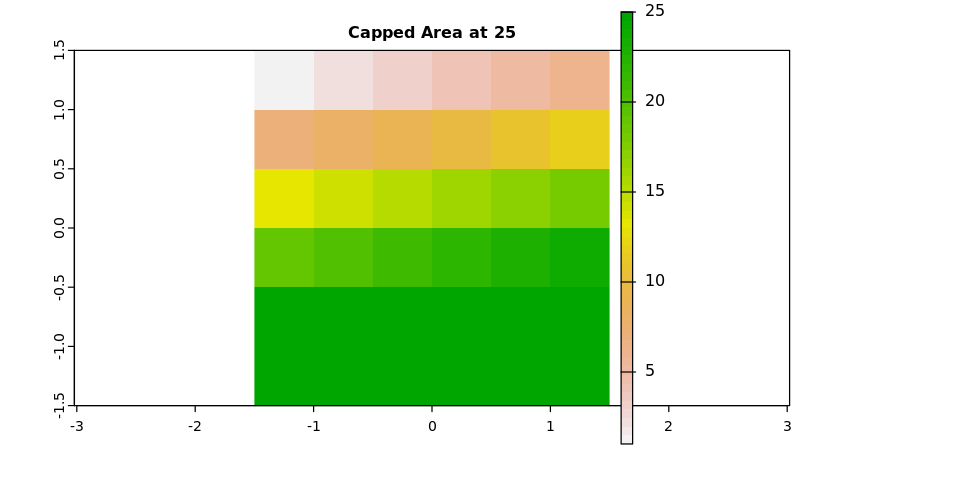

In [50]:
area_cap <- area
area_cap[area_cap >= 25 ] <- 25

# Plot
plot(area_cap, main="Capped Area at 25")

Raster algebra can also be performed on two rasterlayers

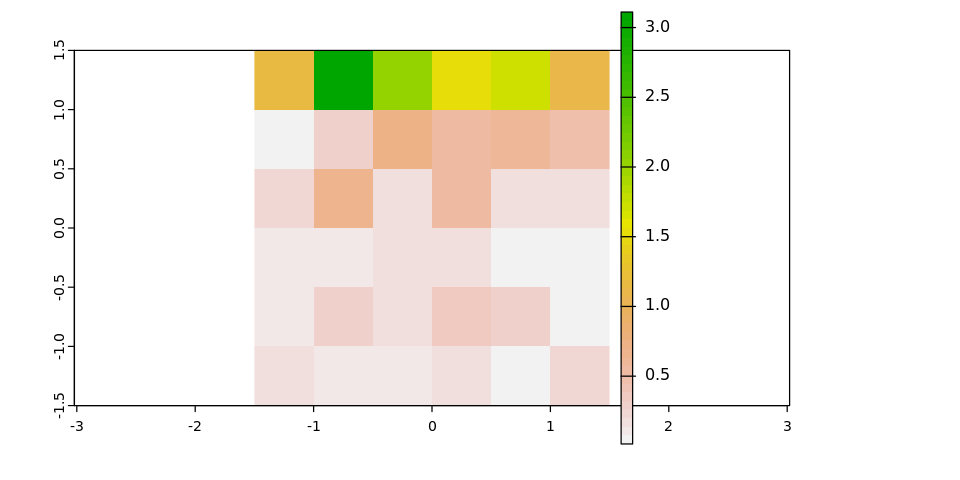

In [51]:
yield <- ras_b/ras_a
plot(yield)

#### **Focal operations**
**Focal** operations take into account a central cell and its neighbors.

The following code chunk applies an aggregation function to all cells within the 
specified neighborhood (in this case 3-by-3 cells), uses the corresponding output 
as the new value for the the central cell, and moves on to the next central cell:

<img src="images/focal_example.png" width=600 alt="GEMS Logo" title="GEMS" />

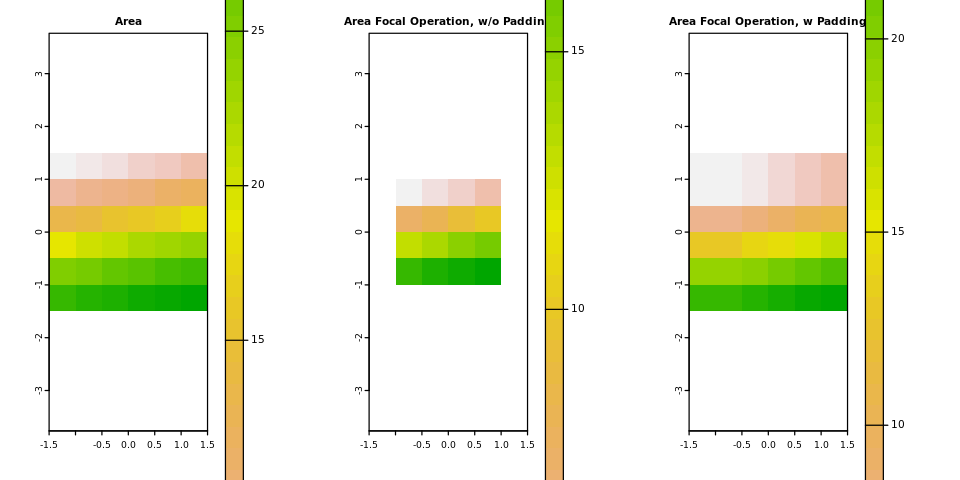

In [53]:
area_focal_1 = focal(area, w = matrix(1, nrow = 3, ncol = 3), fun = min)
area_focal_2 = focal(area, w = matrix(1, nrow = 3, ncol = 3), fun = min, na.rm=TRUE, pad=T, fillvalue=NA)

# Plot
par(mfrow=c(1,3))
plot(area, main="Area")
plot(area_focal_1, main="Area Focal Operation, w/o Padding")
plot(area_focal_2, main="Area Focal Operation, w Padding")

#### **Zonal operations**
**Zonal** operations are similar to focal operations, but the filter can take on any 
shape instead of a predefined rectangular window.

The following code chunk finds the mean area for each soil type:

In [54]:
z <- zonal(area, soil, fun = "mean") 
z

lyr.1,lyr.1
<chr>,<dbl>
clay,15.57143
silt,17.05882
sand,22.25000


#### **Global operations**

**Global** operations are a special case of zonal operations with the entire raster dataset representing a single zone.  
The most common global operations are descriptive statistics for the entire raster dataset such as the minimum or maximum.  
Use `global` if you want a single number summarizing the cell values of each layer.

In [57]:
global(area, fun="max")

,max
,<dbl>
lyr.1,36


In [58]:
global(area, fun='sd')

,sd
,<dbl>
lyr.1,10.53565


<a id="Ex2"></a>
### **<span style='color:Green'> Exercise 2: Map algebra </span>**   

In this exercise, we will practice map algebra using MN SPAM raster on maize harvested area and production.

**Step 1:** Create a raster called `spam_Y_MAIZ_A_mn` which calculates the maize yield at each grid cell in MN using the Production raster `spam_P_MAIZ_A_mn` and Harvested Area raster `spam_H_MAIZ_A_mn`.  

> Yield = Production / Harvested Area    

Plot the maize yield raster map and look at the histogram for yield distribution.


<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Calculate Yield raster file
spam_Y_MAIZ_A_mn <- spam_P_MAIZ_A_mn / spam_H_MAIZ_A_mn

# Plot map
plot(spam_Y_MAIZ_A_mn)

# Histogram
hist(spam_Y_MAIZ_A_mn)
```
----
          
</details>

**Step 2:** Use `focal()` function to create a RasterLayer which calcualtes the mean yield within 3x3 neighborhood grid cells. Then create a raster map that displays the difference between each grid cell's yield and "mean" yield of its neighborhood   

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# focal calculation
spam_Y_MAIZ_A_mn_focal <- focal(spam_Y_MAIZ_A_mn, w = matrix(1, nrow = 3, ncol = 3), fun = mean, na.rm=T, pad=T, padValue=NA)

# plot the yield difference
spam_Y_MAIZ_A_mn_diff <- spam_Y_MAIZ_A_mn - spam_Y_MAIZ_A_mn_focal
plot(spam_Y_MAIZ_A_mn_diff)
```
----
          
</details>

**Step 3:** What's the maximum yield and what's the standard deviation for yield distribution in MN?    

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
global(spam_Y_MAIZ_A_mn, 'max')
global(spam_Y_MAIZ_A_mn, 'sd')
```
----
          
</details>

<a id="GeomOp"></a>

## **Geometry operations**

Modifying geometric objects based on their geometry


### Trim and extend

`trim` crops a RasterLayer by removing the outer rows and columns that only contain NA values.  
In contrast, `extend` adds new rows and/or columns with NA values.  
The purpose of this could be to create a new RasterLayer with the same Extent of another, larger, RasterLayer such that they can be used together in other functions.

In [62]:
area_1 <- area
ext(area_1)

SpatExtent : -1.5, 1.5, -1.5, 1.5 (xmin, xmax, ymin, ymax)

In [65]:
area_2 <- extend(area, c(1, 2)) 
ext(area_2)

SpatExtent : -2.5, 2.5, -2, 2 (xmin, xmax, ymin, ymax)

In [66]:
area_3 <- trim(area_2)
ext(area_3)

SpatExtent : -1.5, 1.5, -1.5, 1.5 (xmin, xmax, ymin, ymax)

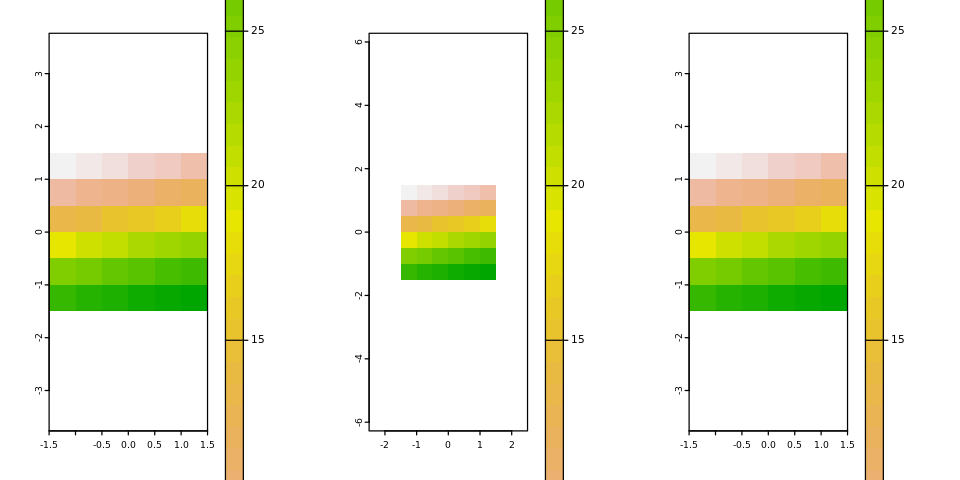

In [67]:
par(mfrow=c(1,3))
plot(area_1)
plot(area_2)
plot(area_3)

### Crop and Merge

The `crop` function lets you take a geographic subset of a larger raster object. You can crop a Raster by providing an extent object or another spatial object from which an extent can be extracted (objects from classes deriving from Raster and from Spatial in the `sp` package). 

The `merge` function lets you merge 2 or more Raster objects into a single new object. The input objects must have the same resolution and origin (such that their cells neatly fit into a single larger raster).

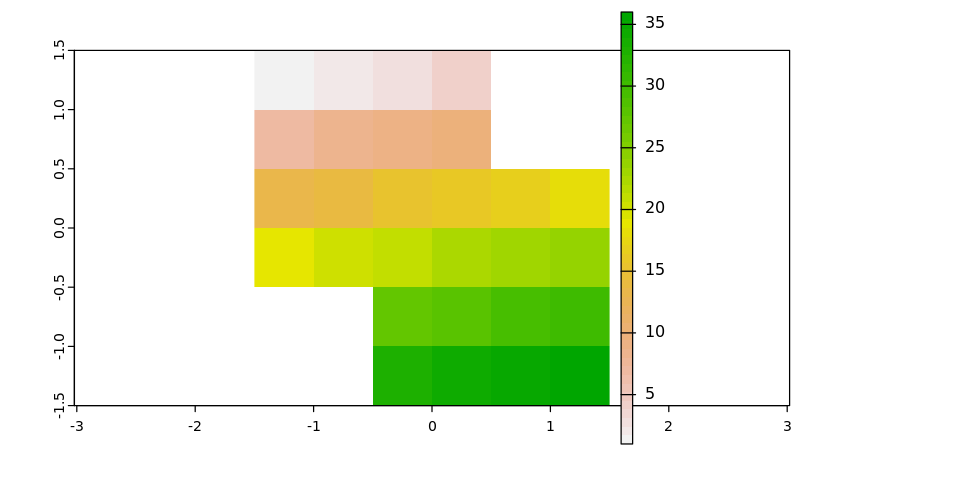

In [79]:
area_c1 = crop(area, extent(-1.5, 0.5, -0.5, 1.5))
area_c2 = crop(area, extent(-0.5, 1.5, -1.5, 0.5))
area_c1c2 = merge(area_c1, area_c2)
plot(area_c1c2)

### Aggregation & disaggregation
`aggregate` and `disaggregate` allow for changing the resolution (cell size) of a `SpatRaster` object. In the case of aggregate, you need to specify a function determining what to do with the grouped cell values. It is possible to specify different (dis)aggregation factors in the x and y direction. `aggregate` and `disaggregate` are the best functions when adjusting cells size only, with an integer step (e.g. each side 2 times smaller or larger). 

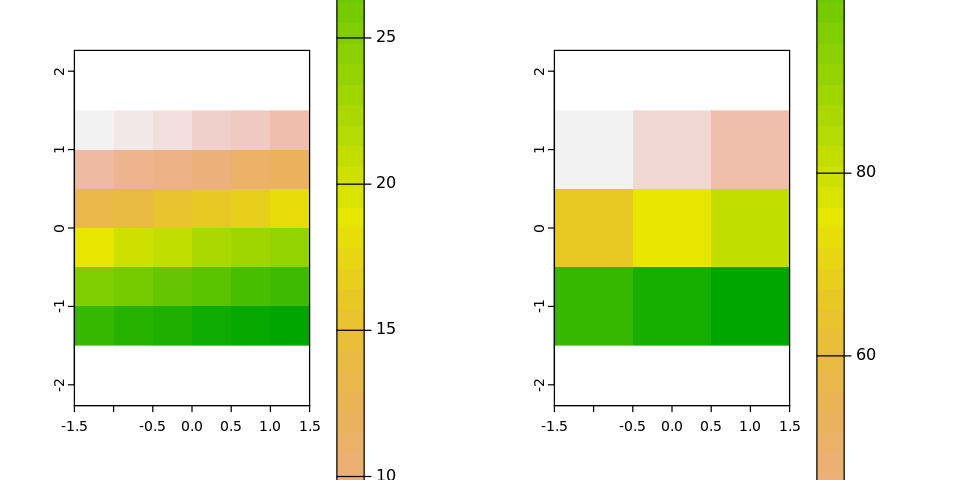

In [80]:
area_agg = aggregate(area, fact=2, fun=sum)

# quick plot
par(mfrow=c(1,2))
plot(area)
plot(area_agg)

To disaggregate a raster object you  have to specify a method on how to fill the new cells.

- **Nearest neighbor** (Default method, `method = ""`): gives all output cells the value of the nearest input cell
- **Bilinear interoploation** (`method = "bilinear"`): uses four nearest pixel centers of the input image to compute an average weighted by distance as the value of the output cell  

Disaggregating is a simple interpolation technique

Corresponding values are only as accurate as their lower resolution source

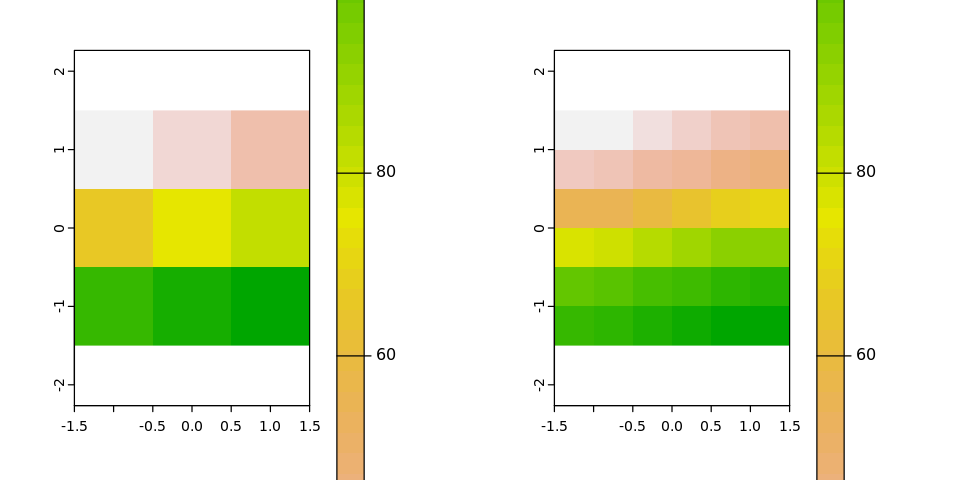

In [83]:
area_nb = disagg(area_agg, fact=2)
area_bi = disagg(area_agg, fact=2, method = "bilinear")

# plot
par(mfrow=c(1,2))
plot(area_nb)
plot(area_bi)

### Reclassify
You can use `classify` cel values to replace ranges of values with single values

0,12,1
12,24,2
24,36,3


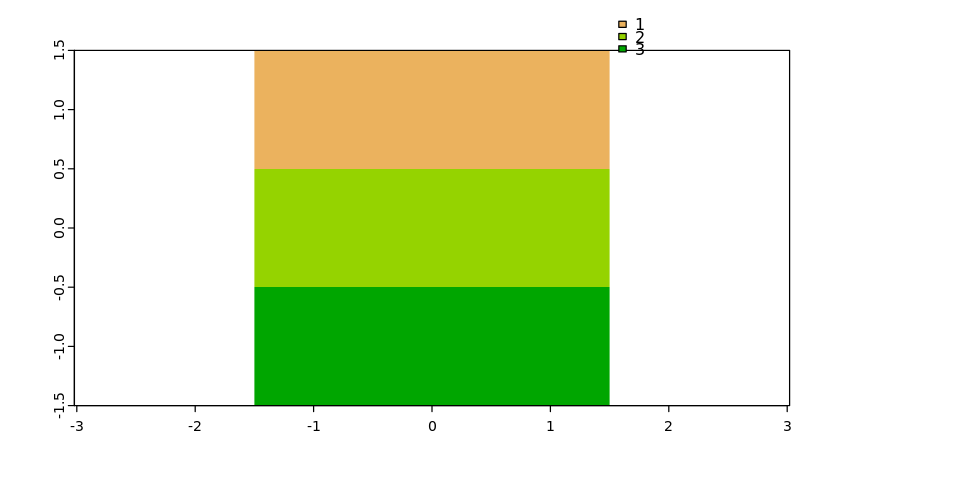

In [85]:
# classify with a 3-column classifying matrix specifying "from-to-becomes" , or a two-column matrix "is-becomes".
rcl = matrix(c(0, 12, 1, 12, 24, 2, 24, 36, 3), ncol = 3, byrow = TRUE)
rcl
area_rcl = classify(area, rcl = rcl)
plot(area_rcl)

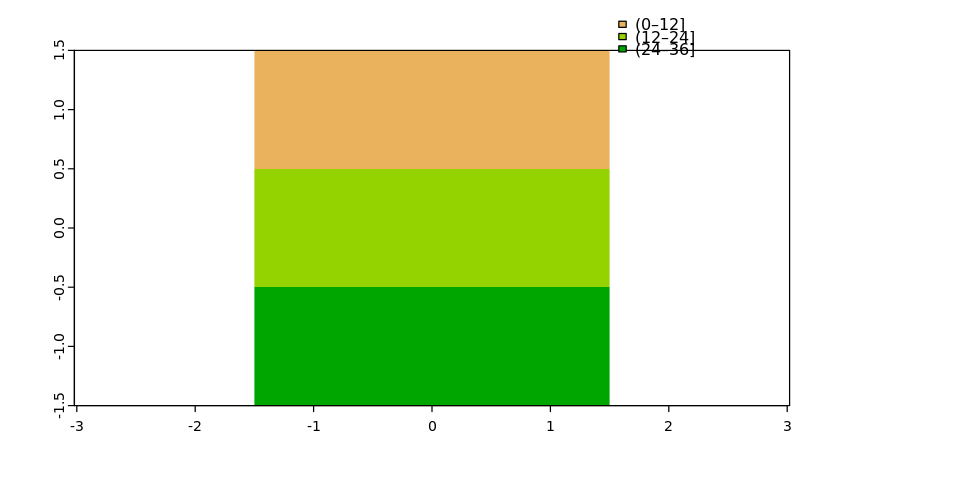

In [87]:
# classify with a vector with "cuts"
breaks <- c(0, 12, 24, 36)
area_cut <- classify(area, breaks)
plot(area_cut)

<a id="Ex3"></a>
### **<span style='color:Green'> Exercise 3: Geometry operations </span>**   

In this exercise, we will practice geometry operations using MN SPAM raster on maize harvested area and production.

**Step 1:** Use `aggregate()` function to create a new RasterLayer from `spam_Y_MAIZ_A_mn` which has a resolution that is 2x lower than the original (use mean value for the new aggregated raster cells).

Plot the aggregated maize yield raster map, check the number of cells in the new rasterlayer and look at the histogram for yield distribution, comparing your results with the original raster


<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Aggregate raster files
spam_Y_MAIZ_A_mn_agg <- aggregate(spam_Y_MAIZ_A_mn, fact=2, fun=mean)

# Plot map
plot(spam_Y_MAIZ_A_mn_agg)

# Number of cells
ncell(spam_Y_MAIZ_A_mn_agg)
ncell(spam_Y_MAIZ_A_mn)

# Histogram
hist(spam_Y_MAIZ_A_mn_agg)
hist(spam_Y_MAIZ_A_mn)
```
----
          
</details>

**Step 2:** Based on the yield distribution (histogram), use `classify()` function to create a RasterLayer which classifies the yield into "low", "mid", "high" groups. Choose your own breaks to do the grouping.

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# matrix method
spam_Y_MAIZ_A_mn_agg_rcl = classify(spam_Y_MAIZ_A_mn_agg, rcl =  matrix(c(0, 7, 1, 7, 10, 2, 10, 15, 3), ncol = 3, byrow = TRUE))
plot(spam_Y_MAIZ_A_mn_agg_rcl,  col = c('yellow', 'orange', 'dark green'))

# cut method
spam_Y_MAIZ_A_mn_agg_cut = classify(spam_Y_MAIZ_A_mn_agg, rcl=c(0, 7, 10, 15), brackets=T)
plot(spam_Y_MAIZ_A_mn_agg_cut,  col = c('yellow', 'orange', 'dark green'))

```
----
          
</details>

<a id="RasVec"></a>

## **Raster-vector interactions**

### Cropping and masking
When the extent of input raster objects are larger than area of interest raster **cropping** and **masking** are useful for unifying the spatial extent of input data.


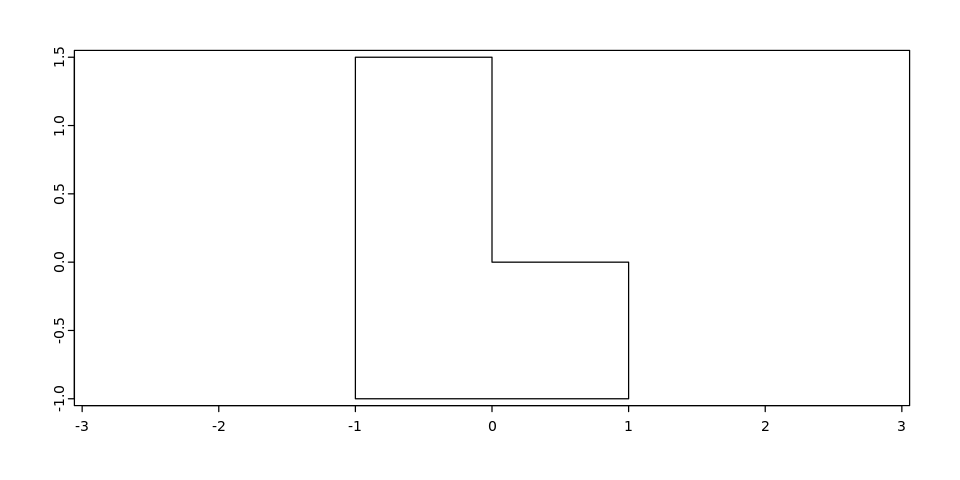

In [103]:
# SpatialPolygons for cropping/masking 
px <- c(0, 0, 1, 1, -1, -1) 
py <- c(1.5, 0, 0, -1, -1, 1.5) 
area_pol <- SpatialPolygons(list(Polygons(list(Polygon(cbind(px,py))), ID="A")))
area_pol <- vect(area_pol)  # Convert to SpatVector
crs(area_pol) <- crs(area)

# plot
plot(area_pol)

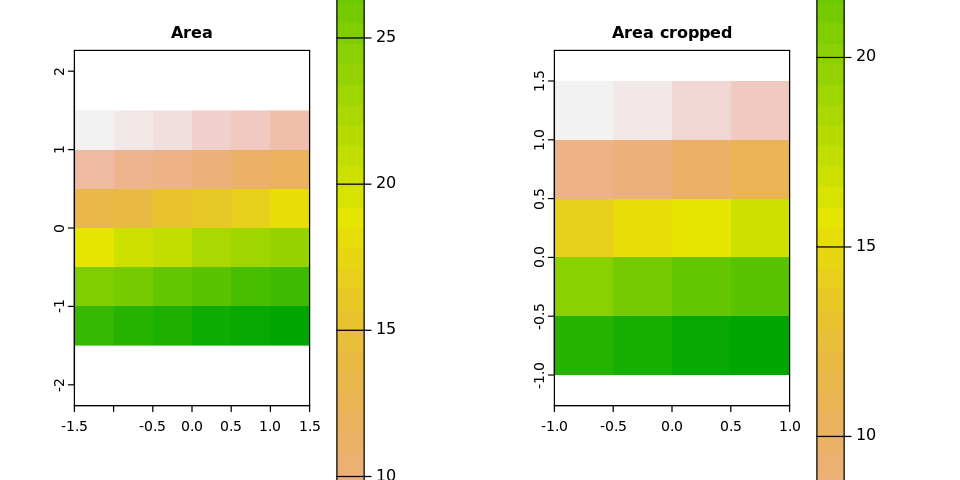

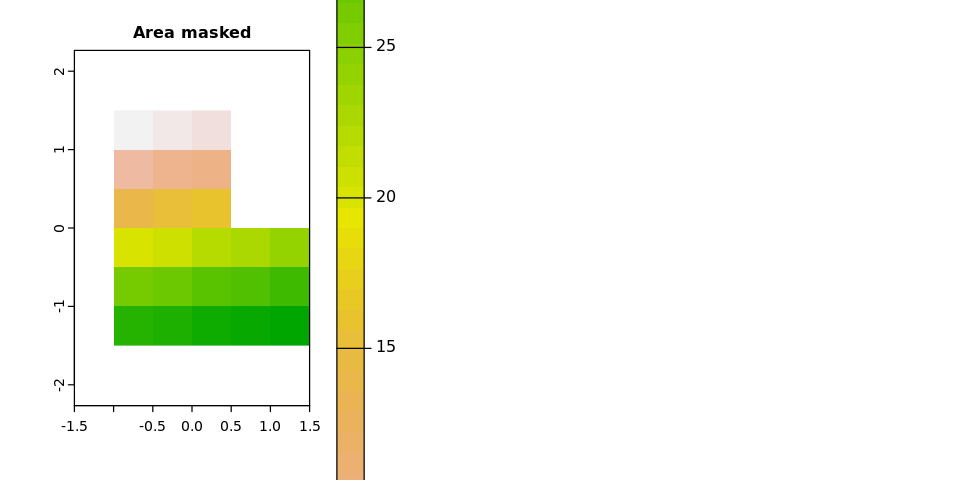

In [106]:
area_cropped = crop(area, area_pol)
area_masked = mask(area, area_pol)

par(mfrow=c(1,2))
plot(area, main="Area")
plot(area_cropped, main="Area cropped")
plot(area_masked, main="Area masked")

## Raster extraction

Raster extraction is the process of identifying and returning the values associated with a 'target' raster at specific locations.

In [107]:
# total area within selected shape
extract(area, area_pol, fun=sum, na.rm=T, df=T)

ID,lyr.1
<dbl>,<dbl>
1,248


## Rasterization  

Rasterization is the conversion of vector objects into their representation in raster objects.

The following code chunk rasterizes an input vector data using a template raster that has the same extent and CRS:

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 
source      : memory 
name        : layer 
min value   :     1 
max value   :     1 

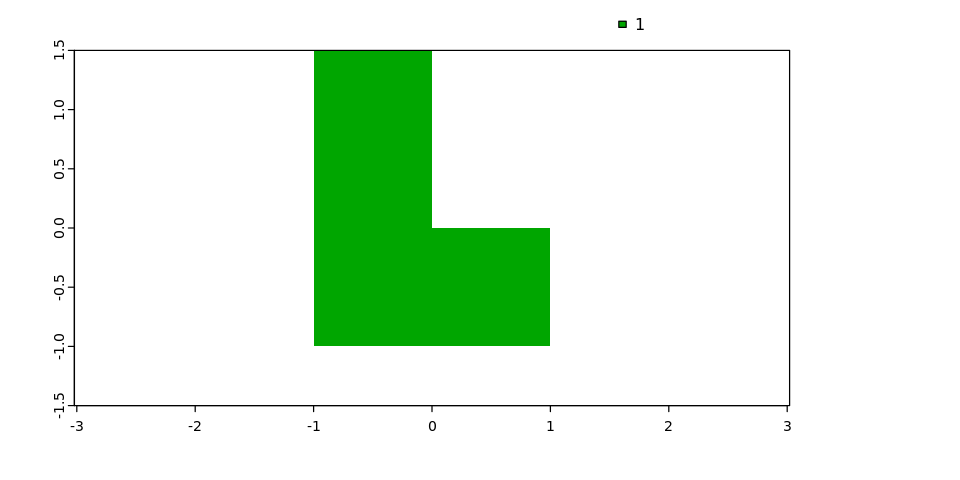

In [108]:
area_pol_ras <- rasterize(area_pol, area)
area_pol_ras
plot(area_pol_ras)

<a id="Ex4"></a>
### **<span style='color:Green'> Exercise 4: Raster-vector interactions </span>**   

In this exercise, we will practice raster-vector interactions

**Step 1:** Read in MN ground water shapefile and select ground water provinces 1,2,3 to mask out maize production raster

- Use `st_read()` function to read in the MN ground water shapefile from `./data/MN/gw_prov`
- Plot the `PROVINCE` attribute using `tmap`.
- Create a subset of ground water PROVINCE 1,2,3 shapefile
- Notice the crs of the ground water shapefile is different from our maize SPAM raster, so first transform the crs to match our maize production raster
- Use `mask` to mask out only maize production in ground water PROVINCE 1,2,3 


<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```

# Read in MN ground water shapefile
gw_prov <- st_read("./data/MN/gw_prov")
summary(gw_prov)

# Plot
tm_shape(gw_prov) +
  tm_polygons("PROVINCE")

# Subset PROVINCE 1, 2, 3
gw_prov123 <- gw_prov[gw_prov$PROVINCE %in% c("1", "2", "3"), ]

# mask
gw_prov123 <- st_transform(gw_prov123, crs=crs(spam_P_MAIZ_A_mn))  # Transform CRS to match
gw_prov123 <- vect(gw_prov123)  # Convert to SpatVector
spam_P_MAIZ_A_mn_mask <- mask(spam_P_MAIZ_A_mn, gw_prov123)

plot(spam_P_MAIZ_A_mn_mask)
```
----
          
</details>

**Step 2:** Use `extract()` to calculate the total maize production within each of the MN water provinces 1, 2, 3
- What's the dimension of the output from `extract()`? Why is that? 
- Add in the "PROVINCE" column to the output data.frame from `extract()`
- Sum by "PROVINCE" to get the province-level total production

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# extract()
geom_sum <- extract(spam_P_MAIZ_A_mn_mask, gw_prov123, fun=sum, na.rm=T, df=T)
geom_sum

# Province level total production
geom_sum$PROVINCE <- gw_prov123$PROVINCE
geom_sum <- as.data.table(geom_sum)
geom_sum[, .(PROD_TOT = sum(spam_P_MAIZ_A_mn)), by=.(PROVINCE)]

```
----
          
</details>

**Step 2:** Use `rasterize()` to calculate the total maize production within MN water provinces 1, 2, 3
- To use `rasterize()`, first need to convert province character to numeric `PROVINCE_CODE`, then rasterize on this field using either min or max function
- Recall we can use `zonal()` function to aggregate one raster (i.e., production) based on another raster (i.e., provinces)
- Compare your results with the `extract()` method

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# rasterize()
gw_prov123$PROVINCE_CODE <- as.numeric(gw_prov123$PROVINCE)
gw_prov123_ras <- rasterize(gw_prov123, spam_P_MAIZ_A_mn_mask, field="PROVINCE_CODE", fun=min)
plot(gw_prov123_ras, breaks=c(0, 1, 2, 3), col=c("red", "blue", "green"))

# zonal calculation
gw_prov123_zonal <- zonal(spam_P_MAIZ_A_mn_mask, gw_prov123_ras, fun = "sum") 
gw_prov123_zonal
```
----
          
</details>

<a id="Ex5"></a>
### **<span style='color:Green'> Additional `terra` learning resources.  </span>**   


Some useful resources to get you started  
>**[The `terra` package](https://rspatial.org/terra/pkg/index.html)**  

>**[A comparison of terra and raster packages](https://www.r-bloggers.com/2021/05/a-comparison-of-terra-and-raster-packages/)**  

>**[Spatial Data Science with R and “terra”](https://rspatial.org/terra/index.html)**

